# <center> Proyecto Pilas: Data Preparation </center>
<center>
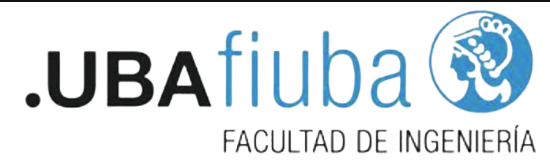
</center>

### <center>Julian Rodriguez Di Sipio y Lucas Argento</center>

## Data Augmentation y Class Balancing

> Para que nuestra red convolucional tenga mas ejemplos de los cuales aprender, vamos a crear nuevas imagenes sinteticas a traves de tecnicas de data augmentation. Entre las tecnicas que vamos a utilizar tenemos:
- Position augmentation
    - Scaling
    - Cropping
    - Flipping
    - Padding
    - Rotation
    - Translation
    - Affine transformation
- Color augmentation
    - Brightness
    - Contrast
    - Saturation
    - Hue

_La informacion sobre estas tecnicas se obtuvo de https://iq.opengenus.org/data-augmentation/_

In [90]:
import PIL.Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [91]:
def position_augmentation(path):
    class_name = path.split("/")[1]
    image_name = path.split("/")[2]
    
    #resize
    loader_transform = transforms.Resize((140, 140))
    img = PIL.Image.open(path)
    transformed = loader_transform(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_resize_transform.jpg", transformed)
    
    #cropping
    loader_transform = transforms.CenterCrop(140)
    img = PIL.Image.open(path)
    transformed = loader_transform(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_center_crop.jpg", transformed)
    
    # horizontal flip with probability 1 (default is 0.5)
    loader_transform = transforms.RandomHorizontalFlip(p=1)
    img = PIL.Image.open(path)
    transformed = loader_transform(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_hor_flip.jpg", transformed)
    
    #rotation
    loader_transform = transforms.RandomRotation(30)
    img = PIL.Image.open(path)
    transformed = loader_transform(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_rotation.jpg", transformed)
    
    # random affine transformation of the image keeping center invariant
    loader_transform = transforms.RandomAffine(0, translate=(0.4, 0.5))
    img = PIL.Image.open(path)
    transformed = loader_transform(img)
    transformed = np.array(transformed)
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_affine.jpg", transformed)

In [102]:
#position_augmentation("Cropped/Duracell/011.jpg")

### A continuación, un ejemplo de las transformaciones de posicición:

- Original:
> 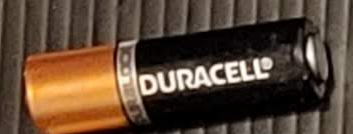

- Rotation:
> 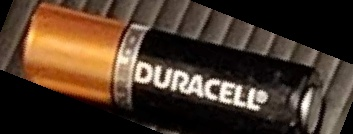

- Resize:
> 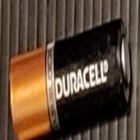

- Horizontal flip:
> 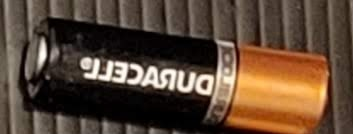

- Center Crop:
> 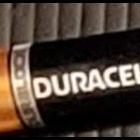

- Affine transformation:
> 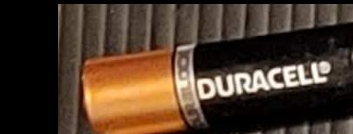

In [95]:
def color_augmentation(path):
    class_name = path.split("/")[1]
    image_name = path.split("/")[2]
    
    img = PIL.Image.open(path)

    # brightness
    loader_transform1 = transforms.ColorJitter(brightness=2)
    transformed = loader_transform1(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_bright.jpg", transformed)
    

    # contrast
    loader_transform2 = transforms.ColorJitter(contrast=2)
    transformed = loader_transform2(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_contrast.jpg", transformed)

    # saturation
    loader_transform3 = transforms.ColorJitter(saturation=2)
    transformed = loader_transform3(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_saturation.jpg", transformed)

    # hue
    loader_transform4 = transforms.ColorJitter(hue=0.2)
    transformed = loader_transform4(img)
    transformed = np.array(transformed) 
    transformed = transformed[:, :, ::-1].copy() 
    cv2.imwrite("Cropped"+"/"+class_name+"/"+image_name+"_hue.jpg", transformed)

In [104]:
#color_augmentation("Cropped/Duracell/011.jpg")

### A continuación, ejemplos de las transformaciones de color para la misma foto:

- brightness
> 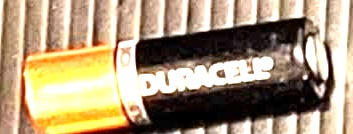
- hue
> 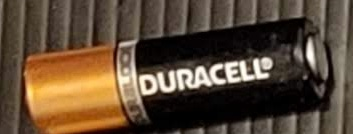
- saturation
> 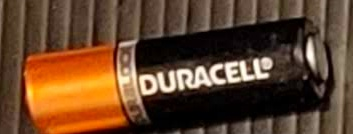
- contrast
> 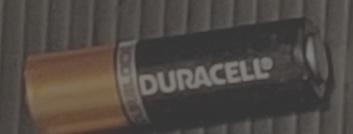

### Genial, ahora vamos a correr lo mismo para todas las fotos de todas las clases:

In [4]:
import os

def get_image_list(directory):
    dir_path = r"Cropped/" + directory

    res = []
    
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            res.append(directory + "/" + path)
    return res

In [100]:
# busco las imagenes originales de todas las clases
cropped_bc = get_image_list("Boton chico")
cropped_bg = get_image_list("Boton grande")
cropped_dura = get_image_list("Duracell")
cropped_ener = get_image_list("Energizer")
cropped_otras = get_image_list("Otras")

In [101]:
# hago el padding resizing
lista_clases = [cropped_bc, cropped_bg, cropped_dura,cropped_ener, cropped_otras]

for clase in lista_clases:
    for image in clase: 
        if "jpg" in image:
            #print(image)
            position_augmentation('Cropped/' + image)
            color_augmentation('Cropped/' + image)

## Homogeneizando los tamaños de las fotos

> Vamos a dejar todas las fotos en un tamaño cuadrado de 300x300. Lo hacemos con padding en color negro al rededor de la foto. En un futuro podria estudiarse un metodo distinto para que la red no gaste recursos en leer pixeles negros que no aportan nada al aprendizaje y la clasificación.

In [1]:
import cv2
import numpy as np
import os

In [2]:
def resize_images(path):
    # read image
    img = cv2.imread(path)
    
    class_name = path.split("/")[1]
    image_name = path.split("/")[2]
    
    old_image_height, old_image_width, channels = img.shape

    # create new image of desired size and color (black) for padding
    new_image_width = 700
    new_image_height = 700
    padding_color = (0,0,0)
    
    result = np.full((new_image_height,new_image_width, channels), padding_color, dtype=np.uint8)
    
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    
    # copy img image into center of result image
    result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = img
    
    # view result
    #cv2.imshow("result", result)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    # save result
    resized_path = "Resized/" + class_name + "/" + image_name
    cv2.imwrite(resized_path, result)

In [5]:
# busco las imagenes originales de todas las clases
cropped_bc = get_image_list("Boton chico")
cropped_bg = get_image_list("Boton grande")
cropped_dura = get_image_list("Duracell")
cropped_ener = get_image_list("Energizer")
cropped_otras = get_image_list("Otras")

In [6]:
# hago el padding resizing
lista_clases = [cropped_bc, cropped_bg, cropped_dura,cropped_ener, cropped_otras]

for clase in lista_clases:
    for image in clase: 
        if "jpg" in image:
            #print(image)
            resize_images('Cropped/' + image)

In [7]:
from PIL import Image
import sys

def resize_aspect_fit(clase):
    path = "Resized/" + clase + "/"
    dirs = os.listdir(path)
    final_size = 128
    for item in dirs:
         if "jpg" in item:
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            size = im.size
            ratio = float(final_size) / max(size)
            new_image_size = tuple([int(x*ratio) for x in size])
            im = im.resize(new_image_size, Image.ANTIALIAS)
            new_im = Image.new("RGB", (final_size, final_size))
            new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
            new_im.save(f + '.jpg', 'JPEG', quality=100)

In [8]:
# tuve que agrandar algunas imagenes para poder hacer el padding, vuelvo a un tamaño mas chico 300x300
clases = ["Boton chico", "Boton grande", "Duracell", "Energizer", "Otras"]
for clase in clases:
    resize_aspect_fit(clase)

/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_3851/1590738342.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize(new_image_size, Image.ANTIALIAS)


In [16]:
total = 0
for clase in lista_clases:
    clases = ["Boton chico", "Boton grande", "Duracell", "Energizer", "Otras"]
    total += len(clase)
    print("La Clase", clases[lista_clases.index(clase)], "tiene: ", len(clase), "Ejemplos")
print("\nSumando un total de ", total, "ejemplos")

La Clase Boton chico tiene:  151 Ejemplos
La Clase Boton grande tiene:  260 Ejemplos
La Clase Duracell tiene:  261 Ejemplos
La Clase Energizer tiene:  931 Ejemplos
La Clase Otras tiene:  850 Ejemplos

Sumando un total de  2453 ejemplos


> Tenemos un problema con nuestro dataset, esta muy desbalanceado. Ya hemos probado de entrenar al modelo y llega a ana accuracy bastante alta, del 90%. sin embargo, la performance es bastante mala ya que le tira a todo lo que ve que es un energizer o una otra. Tenemos que balancear el dataset, para esto vamos a descargar fotos de pilas de las otras clases desde internet

## Balanceando las cantidades de fotos por clase

In [143]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

def get_image_links(query):
    browser = webdriver.Chrome()

    browser.get('https://www.google.com.ar/imghp?hl=es-419&ogbl')

    # search image query
    elem = browser.find_element(By.XPATH, '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input')  # Find the search box
    elem.send_keys(query + Keys.RETURN)

    # find images
    image_links = []
    try:
        i = 1
        elements = browser.find_elements(By.CLASS_NAME, 'rg_i')
        for element in elements:
            image_links.append(element.get_attribute('src'))
        browser.quit()
        return image_links
    except Exception as e:
        print(e)
        browser.quit()
        return image_links

In [144]:
import base64

def download_image(src, name):
    img = src
    img = img.split('base64,/')[1]
    img = "/" + img

    with open(name + ".jpg", "wb") as fh:
        fh.write(base64.b64decode(img))

In [148]:
def search_and_download_N_images(query, class_name, max_images):
    image_list = get_image_links(query)
    for x in range(0, max_images):
        source_file = image_list[x]
        download_image(source_file, class_name + str(x))

In [149]:
# test download just one file
img = images_links[0]
download_image(img, "testo")

In [150]:
# test download many files 
search_and_download_N_images("pila duracell", "Duracell", 10)